# Multi-class classification using pytorch

## import library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as F2
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [ ]:
directory_data  = './sample_data'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

In [ ]:
print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


In [ ]:
for i in x_train[0]:
  print("[")
  for j in i:
    print(j if j != 0 else 0, ",", end=" ")
  print("],")

[
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , ],
[
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , ],
[
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , ],
[
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , ],
[
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0.07109375 , 0.21488972 , 0.36351103 , 0.36351103 , 0.21435356 , 0.06969976 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , ],
[
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0.0036764706 , 0.05514706 , 0.35972732 , 0.6411458 , 0.8800551 , 0.8800551 , 0.63992035 , 0.34551165 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , ],
[
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0.007444853 , 0.057

## number of classes

In [ ]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')

*************************************************
number of classes : 10
*************************************************


## custom data loader for the PyTorch framework

In [ ]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label.astype(int)
    
    def __getitem__(self, index):
        
        image   = self.image[index, :, :]
        label   = self.label[index, ]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.LongTensor([label])

        return image, label
    
    def __len__(self):
        
        return self.image.shape[0]

    def collate_fn(self, batch):
        images  = list()
        labels  = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images  = torch.stack(images, dim=0)
        labels  = torch.stack(labels, dim=0).squeeze()

        return images, labels

## setting device (cpu or gpu)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)
print(type(device))

cpu
<class 'torch.device'>


## construct datasets and dataloaders for training and testing

In [ ]:
# ================================================== 
# determine the value of the following parameter
#
size_minibatch      = 200
#
# ================================================== 
print("x,y train type: ", type(x_train))
dataset_train       = dataset(x_train, y_train)
dataset_test        = dataset(x_test, y_test)
print("dataset() type: ", type(dataset_train))

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_train.collate_fn)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_test.collate_fn)
print("dataloader_train type : ", type(dataloader_train))

x,y train type:  <class 'numpy.ndarray'>
dataset() type:  <class '__main__.dataset'>
dataloader_train type :  <class 'torch.utils.data.dataloader.DataLoader'>


## shape of the data when using the data loader

In [ ]:
image, label    = next(iter(dataloader_train))

In [ ]:
print('************************************************************')
print('size of mini-batch of the image:', image.shape)
print('************************************************************')
print('size of mini-batch of the label:', label.shape)
print('************************************************************')

************************************************************
size of mini-batch of the image: torch.Size([200, 1, 32, 32])
************************************************************
size of mini-batch of the label: torch.Size([200])
************************************************************


## construct a neural network 

In [ ]:
# ================================================== 
# define the neural network architecture
#
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.feature    = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(32, 16, bias=True),
            nn.ReLU(),
            nn.Linear(16, 10, bias=True),
        )

        self.network    = nn.Sequential(
            self.feature,
            nn.Flatten(),
            self.classifier,
        )

        self.initialize()


    def initialize(self):

        for m in self.network.modules():

            if isinstance(m, nn.Conv2d):

                #nn.init.constant_(m.weight, 0.01)
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 1)

            elif isinstance(m, nn.Linear):
    
                #nn.init.constant_(m.weight, 0.01)
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 1)


    def forward(self, input):

        output = self.network(input)

        return output
#
# ================================================== 

In [ ]:
# #### My Test ####
# csfr = Classifier()
# print(type(csfr))
# otp = csfr.forward(image)
# print(type(otp))
# print(otp.shape)
# # print(label.reshape(1, 100).shape)
# # d = F.one_hot(label, num_classes=10)
# cel = nn.CrossEntropyLoss()
# myTest_loss = cel(otp, label)
# print(myTest_loss)

# loss_value = myTest_loss.item()
# print(loss_value)
# print("loss_value type : ", type(loss_value))

# ### argmax ###
# # print(otp)
# argmax_otp = torch.argmax(otp, dim=1)
# print(argmax_otp)
# print(label)
# print( argmax_otp == label)
# print(sum(argmax_otp == label))
# print(label.shape)
# print("len = ", len(label))
# print(type(label.size(dim=0)))

## build network

In [ ]:
# ================================================== 
# determine the value of the following parameter
#
learning_rate   = 0.05
weight_decay    = 0.001
#
# ================================================== 

classifier      = Classifier().to(device)
optimizer       = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
print(classifier)

Classifier(
  (feature): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True

## compute the prediction

In [ ]:
def compute_prediction(model, input):

# ================================================== 
# fill up the blank
# 
    prediction = model.forward(input)
    
#
# ================================================== 

    return prediction

## compute the loss
- use `CrossEntropyLoss`
- compute loss and its value (`loss.item()`)

In [ ]:
def compute_loss(prediction, label):

# ================================================== 
# fill up the blank
#    
 
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(prediction, label)

#
# ================================================== 

    return loss

## compute the loss value

In [ ]:
def compute_loss_value(loss):
    
    loss_value = loss.item()
    
    return loss_value

## compute the accuracy
- accuracy in percentile : 0 - 100 (%)

In [ ]:
def compute_accuracy(prediction, label):

# ================================================== 
# fill up the blank
#         
    argmax_pred = torch.argmax(prediction, dim=1)
    
    accuracy = sum(argmax_pred == label) / label.size(dim=0)

#
# ================================================== 

    return accuracy

## variables for the learning curve

In [ ]:
# ================================================== 
# determine the value of the following parameter
#
number_epoch        = 55
#
# ================================================== 

loss_train_mean     = np.zeros(number_epoch)
loss_train_std      = np.zeros(number_epoch)
accuracy_train_mean = np.zeros(number_epoch)
accuracy_train_std  = np.zeros(number_epoch)

loss_test_mean      = np.zeros(number_epoch)
loss_test_std       = np.zeros(number_epoch)
accuracy_test_mean  = np.zeros(number_epoch)
accuracy_test_std   = np.zeros(number_epoch)

## train and test

In [ ]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    classifier.train()

    for index_batch, (image_train, label_train) in enumerate(dataloader_train):
        # print(index_batch, image_train.shape, label_train.shape)
        image_train = image_train.to(device)
        label_train = label_train.to(device)


# ================================================== 
# fill up the blank
#       
        # mini-batch prediction
        mb_prediction = compute_prediction(classifier, image_train)
        loss_train              = compute_loss(mb_prediction, label_train)
        loss_value_train        = compute_loss_value(loss_train)
        accuracy_train          = compute_accuracy(mb_prediction, label_train)
        
#
# ================================================== 

        loss_train_epoch.append(loss_value_train)
        accuracy_train_epoch.append(accuracy_train)

# ================================================== 
# fill up the blank (update moodel parameters using a mini-batch)
#       
        # optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # gradient descent how to weight update 
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()


#
# ==================================================  


    loss_train_mean[i]      = np.mean(loss_train_epoch)
    loss_train_std[i]       = np.std(loss_train_epoch)

    accuracy_train_mean[i]  = np.mean(accuracy_train_epoch)
    accuracy_train_std[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []
    #  eval() -> because we don't want to update weight parameters
    classifier.eval()

    for index_batch, (image_test, label_test) in enumerate(dataloader_test):

        image_test = image_test.to(device)
        label_test = label_test.to(device)

# ================================================== 
# fill up the blank
#         
        test_prediction = compute_prediction(classifier, image_test)
        loss_test       = compute_loss(test_prediction, label_test)
        loss_value_test = compute_loss_value(loss_test)
        accuracy_test   = compute_accuracy(test_prediction, label_test)
        
#
# ================================================== 
 
        loss_test_epoch.append(loss_value_test)
        accuracy_test_epoch.append(accuracy_test)

    loss_test_mean[i]      = np.mean(loss_test_epoch)
    loss_test_std[i]       = np.std(loss_test_epoch)

    accuracy_test_mean[i]  = np.mean(accuracy_test_epoch)
    accuracy_test_std[i]   = np.std(accuracy_test_epoch)

100%|██████████| 55/55 [04:00<00:00,  4.38s/it]


---

## functions for presenting the results

---

In [ ]:
def function_result_01():

    title           = 'loss (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_mean)), loss_train_mean - loss_train_std, loss_train_mean + loss_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_02():

    title           = 'loss (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_mean)), loss_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_mean)), loss_test_mean - loss_test_std, loss_test_mean + loss_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_03():

    title           = 'accuracy (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_train_mean)), accuracy_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_train_mean)), accuracy_train_mean - accuracy_train_std, accuracy_train_mean + accuracy_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_04():

    title           = 'accuracy (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_test_mean)), accuracy_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_test_mean)), accuracy_test_mean - accuracy_test_std, accuracy_test_mean + accuracy_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_05():

    print('final training accuracy = %9.8f' % (accuracy_train_mean[-1]))

In [ ]:
def function_result_06():

    print('final testing accuracy = %9.8f' % (accuracy_test_mean[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



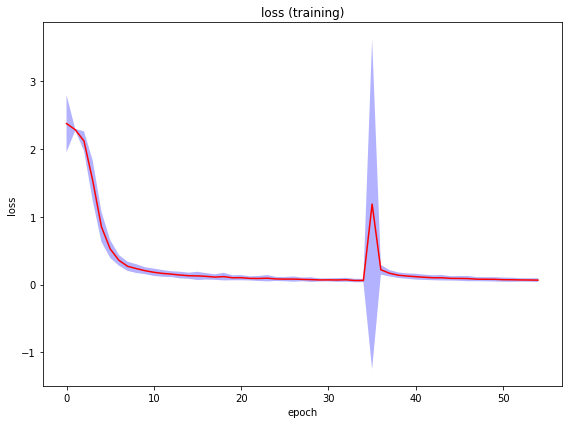


################################################################################
#
# RESULT # 02
#
################################################################################



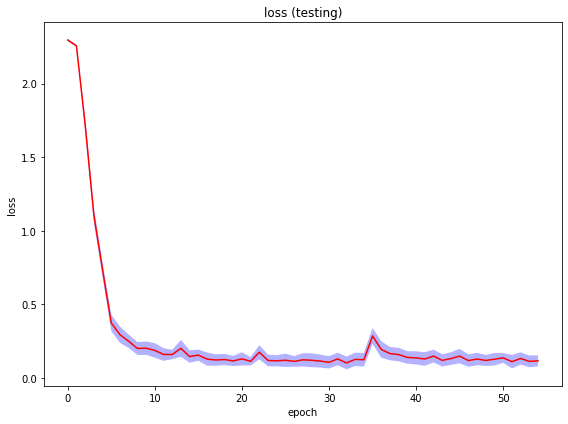


################################################################################
#
# RESULT # 03
#
################################################################################



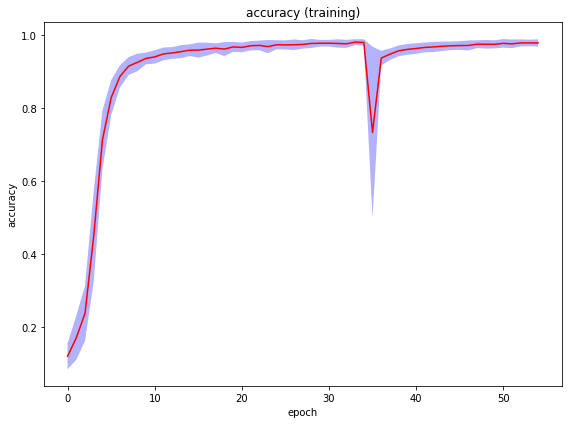


################################################################################
#
# RESULT # 04
#
################################################################################



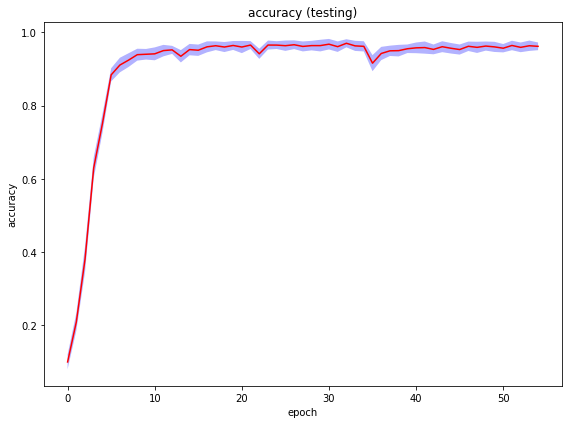


################################################################################
#
# RESULT # 05
#
################################################################################

final training accuracy = 0.97900009

################################################################################
#
# RESULT # 06
#
################################################################################

final testing accuracy = 0.96212500


In [ ]:
number_result = 6 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)

In [ ]:
for param_tensor in classifier.state_dict():
    print(param_tensor, "\t", classifier.state_dict()[param_tensor].size())

feature.0.weight 	 torch.Size([2, 1, 3, 3])
feature.0.bias 	 torch.Size([2])
feature.3.weight 	 torch.Size([4, 2, 3, 3])
feature.3.bias 	 torch.Size([4])
feature.6.weight 	 torch.Size([8, 4, 3, 3])
feature.6.bias 	 torch.Size([8])
feature.9.weight 	 torch.Size([16, 8, 3, 3])
feature.9.bias 	 torch.Size([16])
feature.12.weight 	 torch.Size([32, 16, 3, 3])
feature.12.bias 	 torch.Size([32])
classifier.0.weight 	 torch.Size([16, 32])
classifier.0.bias 	 torch.Size([16])
classifier.2.weight 	 torch.Size([10, 16])
classifier.2.bias 	 torch.Size([10])
network.0.0.weight 	 torch.Size([2, 1, 3, 3])
network.0.0.bias 	 torch.Size([2])
network.0.3.weight 	 torch.Size([4, 2, 3, 3])
network.0.3.bias 	 torch.Size([4])
network.0.6.weight 	 torch.Size([8, 4, 3, 3])
network.0.6.bias 	 torch.Size([8])
network.0.9.weight 	 torch.Size([16, 8, 3, 3])
network.0.9.bias 	 torch.Size([16])
network.0.12.weight 	 torch.Size([32, 16, 3, 3])
network.0.12.bias 	 torch.Size([32])
network.2.0.weight 	 torch.Size([16,

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(classifier.state_dict(), "./drive/MyDrive/capstone.pth")

In [ ]:
loadmodel = Classifier()
loadmodel.load_state_dict(torch.load("./drive/MyDrive/capstone.pth"))
loadmodel.eval()

Classifier(
  (feature): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True

In [ ]:
# 불러온 모델 확인하기
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []
    #  eval() -> because we don't want to update weight parameters
    loadmodel.eval()

    for index_batch, (image_test, label_test) in enumerate(dataloader_test):

        image_test = image_test.to(device)
        label_test = label_test.to(device)

# ================================================== 
# fill up the blank
#         
        test_prediction = compute_prediction(loadmodel, image_test)
        loss_test       = compute_loss(test_prediction, label_test)
        loss_value_test = compute_loss_value(loss_test)
        accuracy_test   = compute_accuracy(test_prediction, label_test)
        
#
# ================================================== 
 
        loss_test_epoch.append(loss_value_test)
        accuracy_test_epoch.append(accuracy_test)

    loss_test_mean[i]      = np.mean(loss_test_epoch)
    loss_test_std[i]       = np.std(loss_test_epoch)

    accuracy_test_mean[i]  = np.mean(accuracy_test_epoch)
    accuracy_test_std[i]   = np.std(accuracy_test_epoch)

100%|██████████| 55/55 [00:40<00:00,  1.36it/s]



################################################################################
#
# RESULT # 01
#
################################################################################



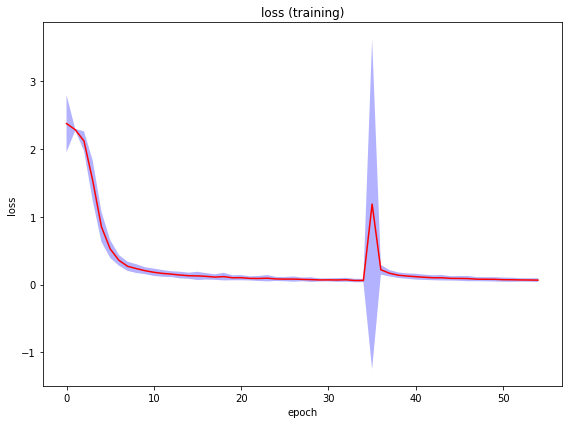


################################################################################
#
# RESULT # 02
#
################################################################################



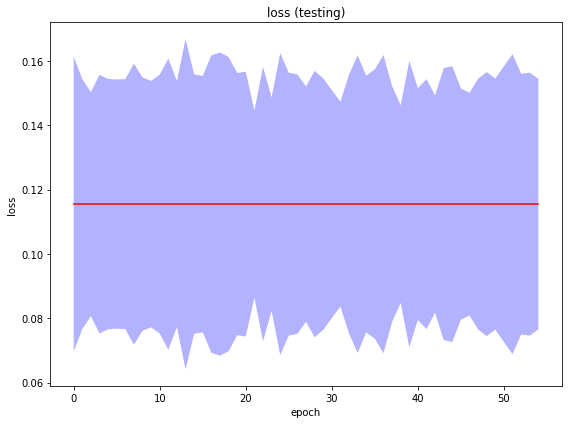


################################################################################
#
# RESULT # 03
#
################################################################################



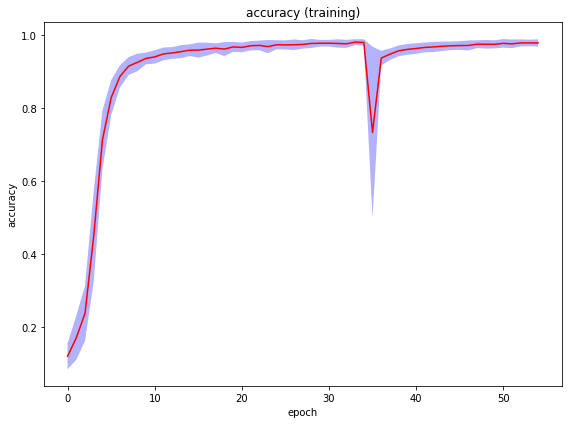


################################################################################
#
# RESULT # 04
#
################################################################################



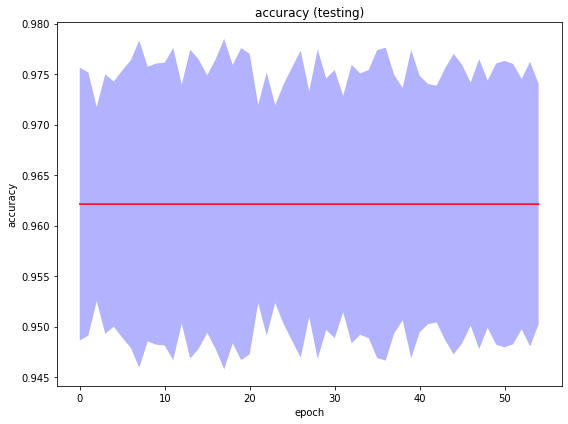


################################################################################
#
# RESULT # 05
#
################################################################################

final training accuracy = 0.97900009

################################################################################
#
# RESULT # 06
#
################################################################################

final testing accuracy = 0.96212500


In [ ]:
number_result = 6 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)

In [ ]:
# 여기서부터 ONNX 모델로 변환 
import io
import torch.utils.model_zoo as model_zoo
import torch.onnx

In [ ]:
xxx = torch.randn(1, 1, 32, 32, requires_grad=True)
torch_out = loadmodel(xxx)

# 모델 변환
torch.onnx.export(loadmodel,               # 실행될 모델
                  xxx,                         # 모델 입력값 (튜플 또는 여러 입력값들도 가능)
                  "./drive/MyDrive/capstone.onnx",   # 모델 저장 경로 (파일 또는 파일과 유사한 객체 모두 가능)
                  export_params=True,        # 모델 파일 안에 학습된 모델 가중치를 저장할지의 여부
                  opset_version=10,          # 모델을 변환할 때 사용할 ONNX 버전
                  do_constant_folding=True,  # 최적화시 상수폴딩을 사용할지의 여부
                  input_names = ['input'],   # 모델의 입력값을 가리키는 이름
                  output_names = ['output'], # 모델의 출력값을 가리키는 이름
                  dynamic_axes={'input' : {0 : '1'},    # 가변적인 길이를 가진 차원
                                'output' : {0 : '1'}})

In [ ]:
# onnx모델델 불러와서서 확인
!pip install onnx


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.1 MB/s 


In [ ]:
import onnx

onnx_model = onnx.load("./drive/MyDrive/capstone.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 5.3 MB/s 
     |████████████████████████████████| 46 kB 3.3 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 


In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("./drive/MyDrive/capstone.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# ONNX 런타임에서 계산된 결과값
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(xxx)}
ort_outs = ort_session.run(None, ort_inputs)

# ONNX 런타임과 PyTorch에서 연산된 결과값 비교
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

In [ ]:
# torch모델과과 onnx모델델 출력값이 같은 것을 알 수 있다.
print(ort_outs)
print(torch_out)

[array([[-0.25228894,  0.9694917 ,  3.6185737 ,  4.341916  , -6.770242  ,
         1.8312073 , -3.368295  ,  0.34477165,  1.532418  , -5.6375575 ]],
      dtype=float32)]
tensor([[-0.2523,  0.9695,  3.6186,  4.3419, -6.7702,  1.8312, -3.3683,  0.3448,
          1.5324, -5.6376]], grad_fn=<AddmmBackward0>)


In [ ]:
!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow


fatal: destination path 'onnx-tensorflow' already exists and is not an empty directory.


In [ ]:
!pip install onnx_tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 226 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 47.9 MB/s 


In [ ]:
import onnx

onnx_model = onnx.load("./drive/MyDrive/capstone.onnx")

In [ ]:
from onnx_tf.backend import prepare

tf_rep = prepare(onnx_model)

In [ ]:
#tf모델로로 변환
tf_rep.export_graph("./drive/MyDrive/capstonet")

In [ ]:
import tensorflow as tf

model = tf.saved_model.load("./drive/MyDrive/capstonet")
model.trainable = False

#input_tensor = tf.random.uniform([1, 1, 32, 32])
input_tensor = tf.random.uniform([1, 1, 32, 32])
out = model(**{'input': input_tensor})
print(out)

{'output': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.9010399 , -1.5039877 ,  2.0773315 ,  2.6085644 , -3.5639937 ,
         0.17304432, -2.4762208 , -2.7499616 ,  4.084781  ,  1.780235  ]],
      dtype=float32)>}


In [ ]:
#tf-lite모델로로 변환
import tensorflow as tf
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("./drive/MyDrive/capstonet")
tflite_model = converter.convert()



In [ ]:
# Save the model
with open("./drive/MyDrive/capstone.tflite", 'wb') as f:
    f.write(tflite_model)


In [ ]:
# tf-lite 추론
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="./drive/MyDrive/capstone.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print(x_train[0].shape)
interpreter.set_tensor(input_details[0]['index'], x_train[2000].reshape(1,1,32,32))

interpreter.invoke()

# get_tensor() returns a copy of the tensor data
# use tensor() in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

##### 이처럼럼 tf-lite& tf input이 같으면 추론결과가 같음을 확인

(32, 32)
[[-1.3648632  10.546681    0.2904622   0.10681134  1.7099004  -0.8634583
  -3.3273585   0.6510863   2.1721153  -1.4859302 ]]


In [ ]:
#여기서부터 torch -> CoreML
torch_model = Classifier()
torch_model.load_state_dict(torch.load("./drive/MyDrive/capstone.pth"))
torch_model.eval()

Classifier(
  (feature): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True

In [ ]:
ptch_to_cml_example_input = torch.rand(1, 1, 32, 32)
ptch_to_cml_traced_model = torch.jit.trace(torch_model, ptch_to_cml_example_input)

In [ ]:
!pip install coremltools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.1 MB/s 


In [ ]:
import torch
import torchvision
import coremltools as ct

In [ ]:
mlmodel = ct.convert(torch_model, inputs=[ct.ImageType()])

ValueError: ignored

In [ ]:
print(mlmodel)

input {
  name: "input_1"
  type {
    multiArrayType {
      shape: 1
      shape: 1
      shape: 32
      shape: 32
      dataType: FLOAT32
    }
  }
}
output {
  name: "var_108"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "torch==1.12.1+cu113"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "6.0"
  }
}



In [ ]:
mlmodel.save("./drive/MyDrive/capstone.mlmodel")